<a href="https://colab.research.google.com/github/Eugene2705/MITx_Supply_Chain_Optimisation/blob/main/SCM_275x_Distance_Based_Demand_Python_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SCM.275x - Advanced Supply Chain Systems Planning and Network Design
# **Distance-Based Demand - Python Exercise**

### *Before starting, make sure to save a copy of this notebook to your Google Drive!*

## **Initialization**

In [1]:
# Import all required packages

import pandas as pd                   # Importing Pandas for data manipulation and analysis
import gurobipy as grb                # Importing Gurobi optimization library for solving mathematical models
import folium                         # Importing Folium for creating interactive maps
import folium.plugins as plugins      # Importing additional plugins for Folium
from folium import Choropleth         # Importing Choropleth from Folium for creating choropleth maps
from geopy.distance import geodesic   # Importing Geopy's geodesic function to calculate distances between two geographic points
import geopandas as gpd               # Importing GeoPandas to work with geospatial data, extending Pandas functionality to handle geometries
import numpy as np                    # Importing NumPy for numerical computations
import matplotlib.pyplot as plt       # Importing Matplotlib for creating static plots
import math                           # Importing Math module

## **Helper functions**

### **Plotting nodes on a map**

In [2]:
# Defining a function to plot nodes on a map using folium

def plot_nodes(map,                         # Folium map object to plot the geographies on
               nodes,                       # Dictionary of node objects where each node contains attributes like latitude and longitude
               icon,                        # Icon symbol to use for the markers on the map
               active_color,                # Color of the marker icon for active nodes
               background_color,            # Background color of the marker icon
               inactive_color = 'grey',     # Color of the marker icon for inactive nodes
               ):

    # Loop through each node in the dictionary
    for node in nodes.values():

        # Create a folium marker
        marker = folium.Marker(
            location=[node.lat, node.lon],              # Set the marker's location
            popup = (node.ID + "-" + node.name),        # Create a marker popup with the node ID and name
            icon=plugins.BeautifyIcon(                  # Create a marker's icon
                icon=icon,
                icon_shape="circle",
                text_color=active_color if node.active == True else inactive_color,
                border_color=active_color if node.active == True else inactive_color,
                background_color=background_color,
            )
        )

        # Add a folium marker to the map
        marker.add_to(map)


### **Computing geodesic distance**

In [3]:
# Defining a function for computing geodesic distances between two locations

def compute_geodesic_distance(origin,       # Origin node object
                              destination,  # Destination node
                              unit='km'):   # Unit ('km' or 'mi')

    # Extract coordinates (latitude and longitude) from origin and destination
    origin_coordinates = [origin.lat, origin.lon]
    destination_coordinates = [destination.lat, destination.lon]

    # Compute distance based on the specified unit
    if unit == 'km':
        distance = geodesic(origin_coordinates, destination_coordinates).km  # Compute distance in kilometers
    elif unit == 'mi':
        distance = geodesic(origin_coordinates, destination_coordinates).mi  # Compute distance in miles

    return distance  # Return the calculated distance


### **Plotting geographies - choropleth map**

In [4]:
# Defining a function for creating a choropleth map

def plot_geographies_choropleth(map,                  # Folium map object to plot the geographies on
                                geographies,          # Dictionary of objects containing geographical data
                                attribute_to_plot,    # Object attribute used to create the map
                                fill_color="YlGn"):   # Color used


    # Create a pandas DataFrame from the geographies for easier plotting
    # Note: getattr() function allows to retrieve an attribute by name; for example: getattr(demand_zone_1, 'selling_price') provides the selling price of the demand_zone_1

    data = pd.DataFrame({
        'ID': [geo.ID for geo in geographies.values()],
        attribute_to_plot: [getattr(geo, attribute_to_plot) for geo in geographies.values()],
        'geometry': [geo.geometry for geo in geographies.values()],
    })


    # Convert the DataFrame to GeoJSON format
    # GeoJSON format is used to represent geographic data in a JSON-like structure. It includes the type of geometry (e.g., Polygon, Point) and the coordinates.

    geo_json_data = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": geo.geometry.__geo_interface__,  # Convert the geometry to GeoJSON format using the __geo_interface__ attribute of the geometry object
                "properties": {"ID": geo.ID, attribute_to_plot: getattr(geo, attribute_to_plot)}
            }
            for geo in geographies.values()
        ]
    }

    # Add a Choropleth layer to the map
    # Choropleth is a type of map where areas are shaded based on the value of a variable, in this case, the 'attribute_to_plot'.

    Choropleth(
        geo_data=geo_json_data,  # Use the GeoJSON data for geometry
        name="choropleth",
        data=data,
        columns=["ID", attribute_to_plot],
        key_on="feature.properties.ID",
        fill_color=fill_color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=attribute_to_plot,
    ).add_to(map)


### **Plotting geographies - categorical map**

In [5]:
def plot_geographies_by_category(map,                   # Folium map object to plot the nodes on
                                 geographies,           # Dictionary of objects containing geographical data
                                 attribute_to_plot,     # Object attribute used to create the map
                                 category_colors):      # Color used

    # Create a pandas DataFrame from the geographies for easier plotting
    data = pd.DataFrame({
        'ID': [geo.ID for geo in geographies.values()],
        attribute_to_plot: [getattr(geo, attribute_to_plot) for geo in geographies.values()],
        'geometry': [geo.geometry for geo in geographies.values()],
    })

    # Convert the DataFrame to GeoJSON format
    geo_json_data = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": geo.geometry.__geo_interface__,  # Convert geometry to GeoJSON format
                "properties": {"ID": geo.ID, attribute_to_plot: getattr(geo, attribute_to_plot)}
            }
            for geo in geographies.values()
        ]
    }

    # Add polygons to the map and color them based on the specified category color mapping
    for _, row in data.iterrows():
        color = category_colors.get(row[attribute_to_plot], "gray")  # Default to 'gray' if category not in category_colors
        folium.GeoJson(
            row['geometry'].__geo_interface__,
            style_function=lambda feature, color=color: {
                'fillColor': color,
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.7,
                'lineOpacity': 0.2,
            },
            tooltip=f"ID: {row['ID']}, {attribute_to_plot}: {row[attribute_to_plot]}"
        ).add_to(map)

    # Add a legend for the categories
    legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: 150px;
                background-color: white; z-index:9999; font-size:14px;">
    <h4>Legend</h4>
    <ul style="list-style-type: none; padding: 0;">"""
    for cat, color in category_colors.items():
        legend_html += f"<li><span style='background-color:{color}; padding:5px;'></span> {cat}</li>"
    legend_html += "</ul></div>"

    map.get_root().html.add_child(folium.Element(legend_html))


## **Data setup and preprocessing**

### **Nodes**

#### Reading input files

In [6]:
# File containing containing demand zone data
demand_zones_file = 'https://raw.githubusercontent.com/scm275/problem_sets_scm275/main/distance-based_demand/demand_zones.json'

# Loading demand zone data into a pandas DataFrame
demand_zones_df = gpd.read_file(demand_zones_file)

# Displaying the first few rows of the DataFrame to verify the data
demand_zones_df.head()

,ID,county,state,lon,lat,max_demand,demand_pct_rank,selling_price,geometry
0,06021,Glenn County,California,-122.391281,39.597389,28.339,0.345361,170,"POLYGON ((-122.91179 39.79948, -122.04647 39.7..."
1,49053,Washington County,Utah,-113.504682,37.280037,197.680,0.706186,170,"POLYGON ((-114.05247 37.60478, -113.5878 37.60..."
2,53063,Spokane County,Washington,-117.404704,47.621276,549.690,0.865979,170,"POLYGON ((-117.82095 47.82578, -117.69777 47.8..."
3,04013,Maricopa County,Arizona,-112.492806,33.347626,1500.000,0.971649,170,"POLYGON ((-113.33505 33.37747, -113.33331 34.0..."
4,53045,Mason County,Washington,-123.186178,47.349623,68.166,0.525773,170,"POLYGON ((-123.50592 47.60462, -122.95062 47.6..."


In [7]:
# File containing warehouse data
warehouse_data_file = 'https://raw.githubusercontent.com/scm275/problem_sets_scm275/main/distance-based_demand/warehouses.csv'

# Loading warehouse data into a pandas DataFrame
warehouses_df = pd.read_csv(warehouse_data_file)

# Displaying the first few rows of the DataFrame to verify the data
warehouses_df.head()

,ID,name,lat,lon,fixed_cost,capacity,landed_cost
0,w1,San Bernandino,34.095457,-117.232554,400000,5000,50
1,w2,Salt Lake City,40.764400,-111.846900,200000,5000,50
2,w3,Portland,45.617900,-122.599070,280000,5000,50
3,w4,Oakland,37.823133,-122.268155,400000,5000,50
4,w5,San Diego,32.790078,-117.069334,240000,5000,50


#### Definition of Classes

In [8]:
# Class representing a DemandZone object

class DemandZone():
    def __init__(self, ID, max_demand, selling_price, lat, lon, state, geometry):
        self.ID = ID                          # DemandZone's ID
        self.max_demand = max_demand          # DemandZone's demand value
        self.selling_price = selling_price    # Initializing an empty dictionnary to store information on selling price
        self.lat = lat                        # DemandZone's latitude
        self.lon = lon                        # DemandZone's longitude
        self.geometry = geometry              # DemandZone's geometry (geospatial data)

        self.demand = dict()                   # Initializing an empty dictionnary to store information on demand



In [9]:
# Class representing a Warehouse object

class Warehouse():
    def __init__(self, ID, name, lat, lon, fixed_cost, capacity, landed_cost):
        self.ID = ID                        # Warehouse's ID
        self.name = name                    # Warehouse's name
        self.lat = lat                      # Warehouse's latitude
        self.lon = lon                      # Warehouse's longitude
        self.fixed_cost = fixed_cost        # Warehouse's fixed cost
        self.capacity = capacity            # Warehouse's capacity
        self.landed_cost = landed_cost      # Warehouse's landed cost

        self.active = True                  # Initializing node as active


#### Creating node objects

In [10]:
# Initializing an empty dictionary to store node objects
nodes = dict()

In [11]:
# Creating a dictionary of demand zone objects

demand_zones = dict()
for i, row in demand_zones_df.iterrows():
    demand_zones[row['ID']] = DemandZone(ID = row['ID'],                          # DemandZone's ID
                                         max_demand = row['max_demand'],          # DemandZone's demand value
                                         selling_price = row['selling_price'],    # DemandZone's selling price
                                         lat = row['lat'],                        # DemandZone's latitude
                                         lon = row['lon'],                        # DemandZone's longitude
                                         state = row['state'],                    # DemandZone's longitude
                                         geometry = row['geometry'])              # DemandZone's geometry (geospatial data)

# Merging the demand zones dictionary into the existing nodes dictionary
nodes = {**nodes, **demand_zones}

In [12]:
# Creating a dictionary of warehouse objects
warehouses = dict()
for i, row in warehouses_df.iterrows():
    warehouses[row['ID']] = Warehouse(ID = row['ID'],                     # Warehouse's ID
                                    name = row['name'],                   # Warehouse's name
                                    lat = row['lat'],                     # Warehouse's latitude
                                    lon = row['lon'],                     # Warehouse's longitude
                                    fixed_cost = row['fixed_cost'],       # Warehouse's fixed cost
                                    capacity = row['capacity'],           # Warehouse's fixed cost
                                    landed_cost = row['landed_cost'])     # Warehouse's landed cost

# Merging the warehouses dictionary into the existing nodes dictionary
nodes = {**nodes, **warehouses}

#### Visualizing node objects

In [13]:
# Create a new map
map = folium.Map([40, -100.0], zoom_start=5)

# Plot warehouse locations with a warehouse icon, blue color, and white background
plot_nodes(map=map, nodes=warehouses, icon='warehouse', active_color='blue', background_color='white')

# Plot demand zones on a map
plot_geographies_choropleth(map=map, geographies=demand_zones, attribute_to_plot='max_demand', fill_color = 'YlGnBu')

# Add a tile layer for better map visualization (cartodbpositron theme)
folium.TileLayer('cartodbpositron').add_to(map)

# Display the map with all the plotted data
map


### **Arcs**

#### Arc distances

In [14]:
# Creating a dictionary containing distances between warehouses and demand_zones
distances = dict()
for w, warehouse in warehouses.items():
  for d, demand_zone in demand_zones.items():
      distances[w, d] = compute_geodesic_distance(origin = warehouse, destination = demand_zone, unit = 'km')

#### Arc costs

***❗Task 1: Modify the cost per unit per kilometer to 0.3 and rerun the model.***

In [20]:
cost_unit_km = 0.3    # Cost per unit per kilometer from warehouse to demand zones

# Creating a dictionary containing unit costs between warehouses and demand zones
unit_cost = dict()

for w, warehouse in warehouses.items():                                                        # Iterate over warehouses
    for d, demand_zone in demand_zones.items():                                                # Iterate over demand zones
        unit_cost[w, d] = distances[w, d] * cost_unit_km                                       # Calculate unit cost as distance multiplied by cost per km (warehouse to demand zone)


### **Preprocessing demand**

Text(0.5, 0, 'Distance')

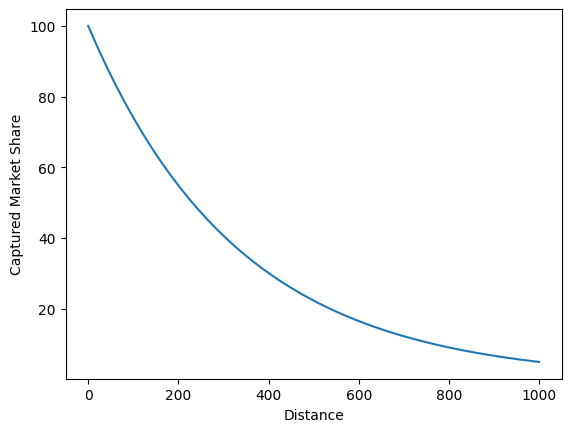

In [21]:
# Defining the rate of decay of potential demand with distance
k = 0.003

# Ploting the captured market share as a function of distance
distance = np.linspace(0, 1000, 50)
market_share = [100 * math.exp(- k * d) for d in distance]
plt.plot(distance, market_share)
plt.ylabel('Captured Market Share')
plt.xlabel('Distance')

In [22]:
# Defining captured demand for each combination of warehouses and demand zones

for w, warehouse in warehouses.items():
    for d, demand_zone in demand_zones.items():
        demand_zone.demand[w] = demand_zone.max_demand * math.exp(-k * distances[w, d])

## **Optimization model**

### **Creating and solving the optimization model**

In [23]:
# Initializing the model
model = grb.Model("Distance-dependent demand")

# Creating decision variables

# Binary variables for warehouse locations
wh_location_vars = dict()
for w, warehouse in warehouses.items():
    wh_location_vars[w] = model.addVar(vtype=grb.GRB.BINARY,
                                       name="wh_location_{0}".format(w))


# Binary allocation variables for demand zone to warehouse assignments
allocation_vars = dict()
for w, warehouse in warehouses.items():
    for d, demand_zone in demand_zones.items():
        allocation_vars[w, d] = model.addVar(vtype=grb.GRB.BINARY,
                                             name="allocation_{0}_{1}".format(w, d))

# Revenue
revenue = grb.quicksum(demand_zone.selling_price * allocation_vars[w, d] * demand_zone.demand[w]
                       for w, warehouse in warehouses.items() for d, demand_zone in demand_zones.items())

fixed_cost_warehouses = grb.quicksum(warehouse.fixed_cost * wh_location_vars[w]
                                     for w, warehouse in warehouses.items())

transportation_cost = grb.quicksum(unit_cost[w, d] * allocation_vars[w, d] * demand_zone.demand[w]
                                   for w, warehouse in warehouses.items() for d, demand_zone in demand_zones.items())

landed_cost = grb.quicksum(warehouse.landed_cost * allocation_vars[w, d] * demand_zone.demand[w]
                                   for w, warehouse in warehouses.items() for d, demand_zone in demand_zones.items())

# Define the profit function as the objective
profit = revenue - fixed_cost_warehouses - landed_cost - transportation_cost
model.setObjective(profit, grb.GRB.MAXIMIZE)

# Adding constraints to ensure warehouse capacity is not exceeded
for w, warehouse in warehouses.items():
    model.addConstr(grb.quicksum(allocation_vars[w, d] * demand_zone.demand[w] for d, demand_zone in demand_zones.items()) <= warehouse.capacity*wh_location_vars[w])

# Adding constraints to ensure each demand zone is allocated to at most one warehouse
for d, demand_zone in demand_zones.items():
    model.addConstr(grb.quicksum(allocation_vars[w, d] for w, warehouse in warehouses.items()) <= 1)

# Optimizing the model
model.optimize()

# Set the activation decisions of the warehouses
for w, warehouse in warehouses.items():
  warehouse.active = True if wh_location_vars[w].X == 1 else False


# Set the captured market share and the serving warehouse of the demand zone
for d, demand_zone in demand_zones.items():
  demand_zone.captured_ms = 0
  demand_zone.serving_warehouse = 'none'
  for w, warehouse in warehouses.items():
    if allocation_vars[w, d].X == 1:
      demand_zone.captured_ms = demand_zone.demand[w] / demand_zone.max_demand
      demand_zone.serving_warehouse = w


Restricted license - for non-production use only - expires 2026-11-23


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 202 rows, 1560 columns and 3112 nonzeros
Model fingerprint: 0x391443ed
Variable types: 0 continuous, 1560 integer (1560 binary)
Coefficient statistics:
  Matrix range     [3e-02, 5e+03]
  Objective range  [1e-01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 81 rows and 1245 columns
Presolve time: 0.01s
Presolved: 121 rows, 315 columns, 601 nonzeros
Found heuristic solution: objective 80667.972935
Variable types: 0 continuous, 315 integer (315 binary)

Root relaxation: objective 1.047490e+06, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

In [25]:
# Create a new map
map = folium.Map([40, -100.0], zoom_start=5)

# Plot warehouse locations with a warehouse icon, blue color, and white background
plot_nodes(map=map, nodes=warehouses, icon='warehouse', active_color='blue', background_color='white')

# Plot demand zones on a map
plot_geographies_choropleth(map=map, geographies=demand_zones, attribute_to_plot='captured_ms', fill_color = 'YlGnBu')

# Add a tile layer for better map visualization (cartodbpositron theme)
folium.TileLayer('cartodbpositron').add_to(map)

# Display the map with all the plotted data
map


In [26]:
# Get a list of active warehouses

for w, warehouse in warehouses.items():
  if warehouse.active == True:
    print(w)

w2
w3
w4
w5
w6
w8


In [29]:
# Create a new map
map = folium.Map([40, -100.0], zoom_start=5)

# Plot warehouse locations with a warehouse icon, blue color, and white background
plot_nodes(map=map, nodes=warehouses, icon='warehouse', active_color='blue', background_color='white')

category_colors = {
    'none': 'white',
    'w2': 'green',
    'w3': 'red',
    'w4': 'pink',
    'w5': 'blue',
    'w6': 'yellow',
    'w8': 'orange'
}

# Plot demand zones on a map and show the serving warehouse
plot_geographies_by_category(map, geographies=demand_zones, attribute_to_plot="serving_warehouse", category_colors = category_colors)

# Add a tile layer for better map visualization (cartodbpositron theme)
folium.TileLayer('cartodbpositron').add_to(map)

# Display the map with all the plotted data
map
